# Triangular Moving Average (TMA) — Crypto Backtester (Yahoo Finance)

This notebook implements two TMA strategies for **crypto tickers on Yahoo Finance**:

1. **Price vs. TMA** — go long when `Close > TMA(n)`, exit (or flip short) when `Close < TMA(n)`  
2. **Double‑TMA crossover** — go long when `TMA(fast) > TMA(slow)`, exit (or flip short) on cross down

> Educational use only. Not financial advice.


In [17]:
# Install minimal dependencies (uncomment if running locally)
# %pip install pandas numpy matplotlib


In [18]:
import math
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 4)


In [19]:
DATA_DIR = (Path.cwd() / "data").resolve()

def load_cached_close(symbol: str, start: str | None = None, end: str | None = None) -> pd.Series:
    """Load close price series from cached Binance CSVs."""
    path = DATA_DIR / f"{symbol}.csv"
    if not path.exists():
        raise FileNotFoundError(f"Cached data not found for {symbol}. Expected file: {path}")
    df = pd.read_csv(path, parse_dates=["open_time"])
    df = df.rename(columns=str.lower)
    df.set_index("open_time", inplace=True)
    if getattr(df.index, "tz", None) is not None:
        df.index = df.index.tz_convert("UTC").tz_localize(None)
    if start is not None:
        df = df.loc[df.index >= pd.Timestamp(start)]
    if end is not None:
        df = df.loc[df.index <= pd.Timestamp(end)]
    close = df["close"].astype(float)
    close.name = symbol
    return close


In [20]:
def triangular_moving_average(series: pd.Series, window: int) -> pd.Series:
    """TMA: SMA of an SMA with half-up/half-down windows."""
    if window < 2:
        raise ValueError("window must be >= 2")
    w1 = math.ceil((window + 1) / 2)
    w2 = math.floor((window + 1) / 2)
    return series.rolling(w1, min_periods=w1).mean().rolling(w2, min_periods=w2).mean()


In [21]:
def infer_annualization_factor(index: pd.DatetimeIndex) -> float:
    if len(index) < 3:
        return 365.25
    deltas = pd.Series(index).diff().dt.total_seconds().dropna()
    median_days = float(deltas.median()) / 86400.0
    if median_days <= 0:
        return 365.25
    return 365.25 / median_days

def max_drawdown(equity: pd.Series):
    roll_max = equity.cummax()
    dd = equity / roll_max - 1.0
    end = dd.idxmin()
    start = equity.loc[:end].idxmax()
    return float(dd.min()), start, end

def equity_curve_from_returns(returns: pd.Series, start_value: float = 1.0) -> pd.Series:
    return start_value * (1.0 + returns.fillna(0.0)).cumprod()

@dataclass
class Metrics:
    ticker: str
    total_return: float
    cagr: float
    sharpe: float
    max_dd: float
    calmar: float
    trades: int
    win_rate: float
    avg_trade: float
    profit_factor: float
    bh_total_return: float
    bh_cagr: float


In [22]:
def build_trade_book(df_cp: pd.DataFrame, fee_rate: float) -> pd.DataFrame:
    close = df_cp["close"]
    pos = df_cp["pos"].astype(int)
    events = pos.diff().fillna(pos.iloc[0]).replace(np.nan, 0)

    book = []
    cur_pos = 0
    entry_price = None
    entry_time = None

    for t, change in events.items():
        new_pos = int(pos.loc[t])

        if new_pos != cur_pos and cur_pos != 0 and entry_price is not None:
            exit_price = close.loc[t]
            side = "long" if cur_pos == 1 else "short"
            gross = (exit_price / entry_price - 1.0) if cur_pos == 1 else (entry_price / exit_price - 1.0)
            net = gross - 2 * fee_rate
            book.append({
                "entry_time": entry_time, "exit_time": t,
                "side": side, "gross_return": gross, "net_return": net
            })
            entry_price = None
            entry_time = None

        if new_pos != cur_pos and new_pos != 0:
            entry_price = close.loc[t]
            entry_time = t

        cur_pos = new_pos

    if cur_pos != 0 and entry_price is not None:
        t = close.index[-1]
        exit_price = close.iloc[-1]
        side = "long" if cur_pos == 1 else "short"
        gross = (exit_price / entry_price - 1.0) if cur_pos == 1 else (entry_price / exit_price - 1.0)
        net = gross - 2 * fee_rate
        book.append({
            "entry_time": entry_time, "exit_time": t,
            "side": side, "gross_return": gross, "net_return": net
        })

    return pd.DataFrame(book)


In [23]:
def backtest_tma(
    close: pd.Series,
    mode: str = "double_tma",
    tma_window: int = 80,
    fast: int = 20,
    slow: int = 50,
    allow_short: bool = False,
    fee_bps: float = 10.0,
    make_plots: bool = False
):
    df = pd.DataFrame({"close": close.dropna()})
    if mode == "price_cross":
        tma = triangular_moving_average(df["close"], tma_window)
        df["tma"] = tma
        df = df.dropna()
        long_signal = df["close"] > df["tma"]
        df["pos"] = np.where(long_signal, 1, (-1 if allow_short else 0))
        signal_name = f"Price>TMA{tma_window}"
    elif mode == "double_tma":
        tma_fast = triangular_moving_average(df["close"], fast)
        tma_slow = triangular_moving_average(df["close"], slow)
        df["tma_fast"] = tma_fast
        df["tma_slow"] = tma_slow
        df = df.dropna()
        long_signal = df["tma_fast"] > df["tma_slow"]
        df["pos"] = np.where(long_signal, 1, (-1 if allow_short else 0))
        signal_name = f"TMA{fast}>TMA{slow}"
    else:
        raise ValueError("mode must be one of {'price_cross', 'double_tma'}")

    df["ret"] = df["close"].pct_change().fillna(0.0)
    fee_rate = fee_bps / 10000.0
    pos = df["pos"].astype(float)
    pos_shift = pos.shift(1).fillna(0.0)
    pos_change = pos - pos_shift
    strat = pos_shift * df["ret"]
    fees_today = pos_change.abs() * fee_rate
    df["strat_ret"] = strat - fees_today

    df["eq"] = 1.0 * (1.0 + df["strat_ret"]).cumprod()
    df["bh_eq"] = 1.0 * (1.0 + df["ret"]).cumprod()

    ann = infer_annualization_factor(df.index)
    daily = df["eq"].pct_change().dropna()
    sharpe = (daily.mean() / (daily.std() + 1e-12)) * math.sqrt(ann)

    total_return = float(df["eq"].iloc[-1] - 1.0)
    bh_total_return = float(df["bh_eq"].iloc[-1] - 1.0)
    n_years = max((df.index[-1] - df.index[0]).days / 365.25, 1e-9)
    cagr = float(df["eq"].iloc[-1]) ** (1.0 / n_years) - 1.0
    bh_cagr = float(df["bh_eq"].iloc[-1]) ** (1.0 / n_years) - 1.0

    mdd, dd_start, dd_end = max_drawdown(df["eq"])
    calmar = (cagr / abs(mdd)) if mdd < 0 else float("nan")

    trades = build_trade_book(df[["close", "pos"]], fee_rate)
    if len(trades) > 0:
        win_rate = float((trades["net_return"] > 0).mean())
        avg_trade = float(trades["net_return"].mean())
        gross_profit = trades.loc[trades["net_return"] > 0, "net_return"].sum()
        gross_loss = -trades.loc[trades["net_return"] < 0, "net_return"].sum()
        profit_factor = (gross_profit / gross_loss) if gross_loss > 0 else float("inf")
    else:
        win_rate, avg_trade, profit_factor = (float("nan"), float("nan"), float("nan"))

    metrics = Metrics(
        ticker=str(close.name),
        total_return=total_return,
        cagr=cagr,
        sharpe=sharpe,
        max_dd=mdd,
        calmar=calmar,
        trades=int(len(trades)),
        win_rate=win_rate,
        avg_trade=avg_trade,
        profit_factor=profit_factor,
        bh_total_return=bh_total_return,
        bh_cagr=bh_cagr,
    )

    if make_plots:
        plt.plot(df.index, df["eq"], label="Strategy equity")
        plt.plot(df.index, df["bh_eq"], label="Buy & hold")
        plt.title(f"{str(close.name)} — Equity ({signal_name})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.plot(df.index, df["close"], label="Close")
        if mode == "price_cross":
            plt.plot(df.index, df["tma"], label=f"TMA({tma_window})")
        else:
            plt.plot(df.index, df["tma_fast"], label=f"TMA({fast})")
            plt.plot(df.index, df["tma_slow"], label=f"TMA({slow})")
        plt.title(f"{str(close.name)} — Price & TMA(s)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return metrics, df, trades


## Example run (BTC-USD, double TMA)

Feel free to edit `fast`, `slow`, or switch `mode` to `price_cross` and add `tma_window`.


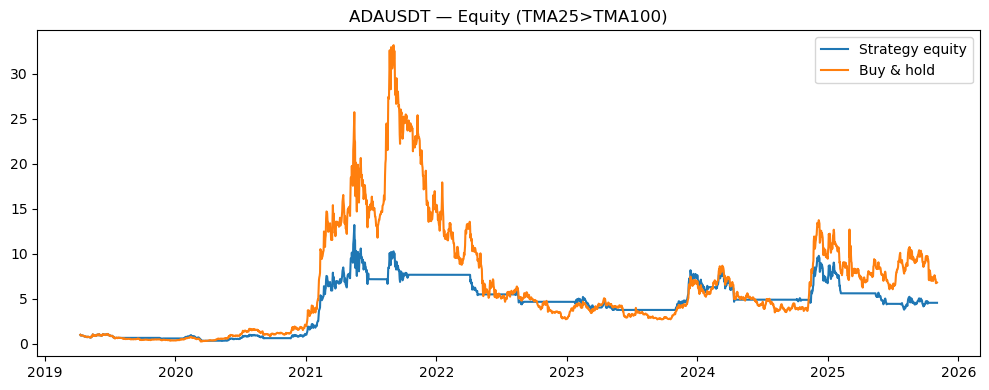

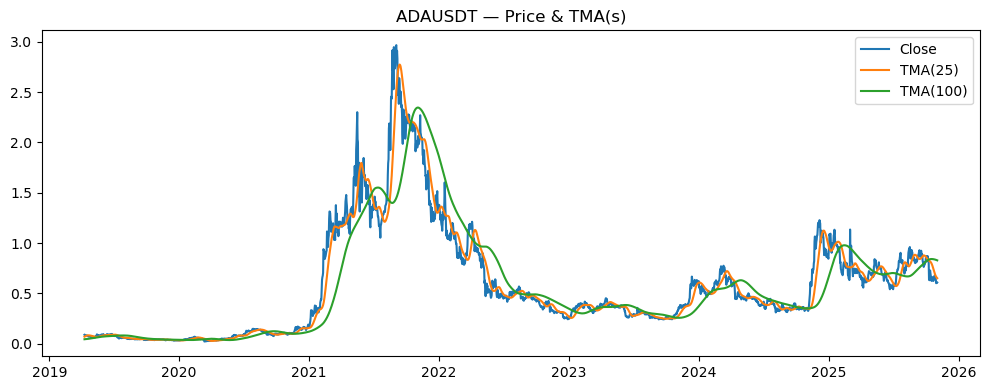

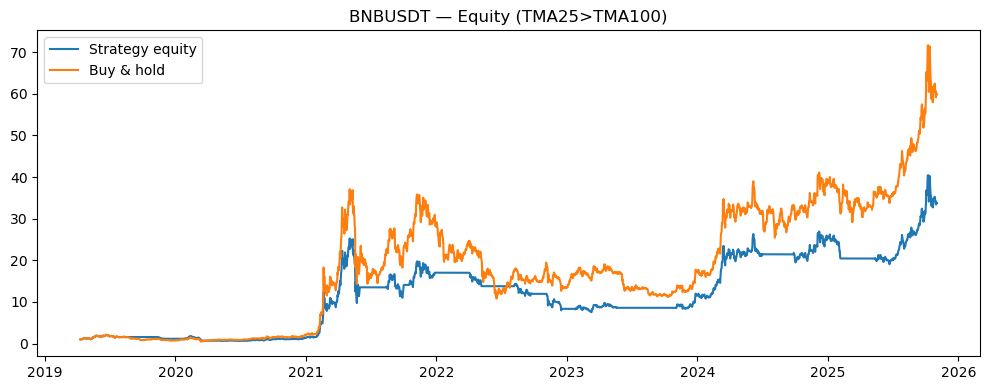

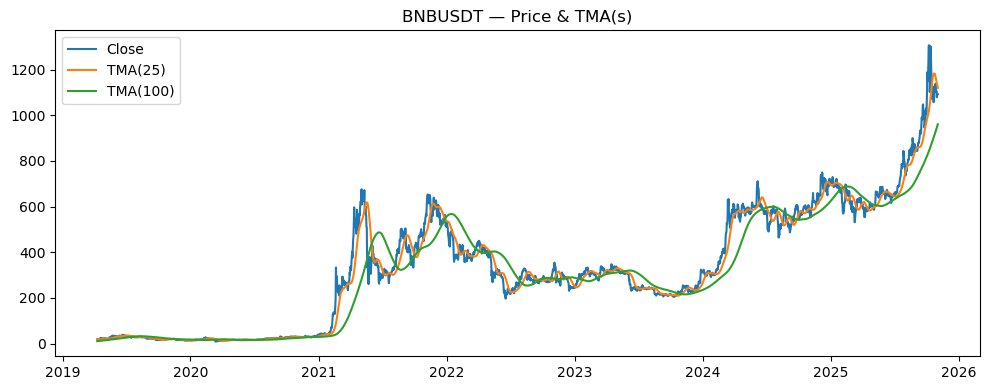

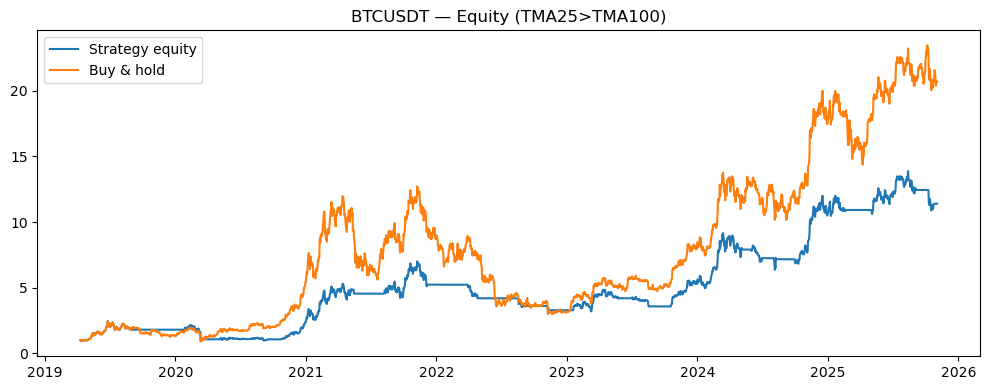

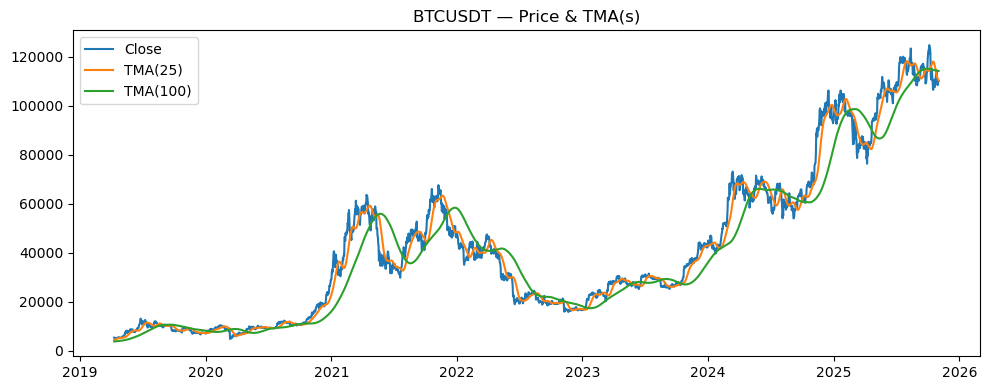

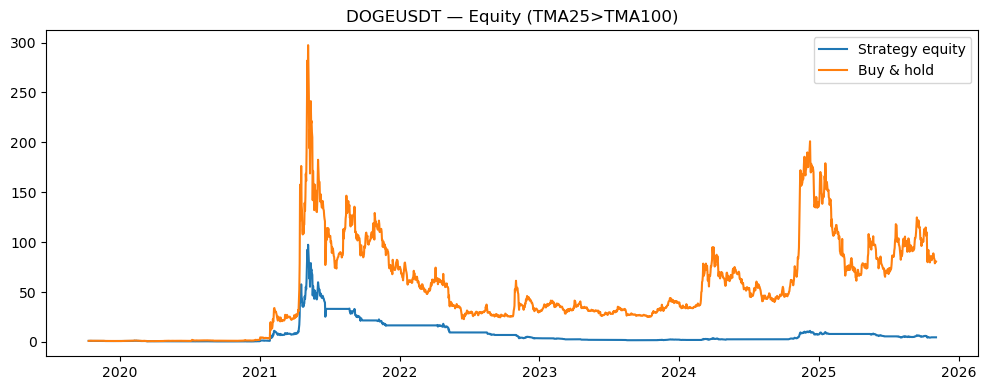

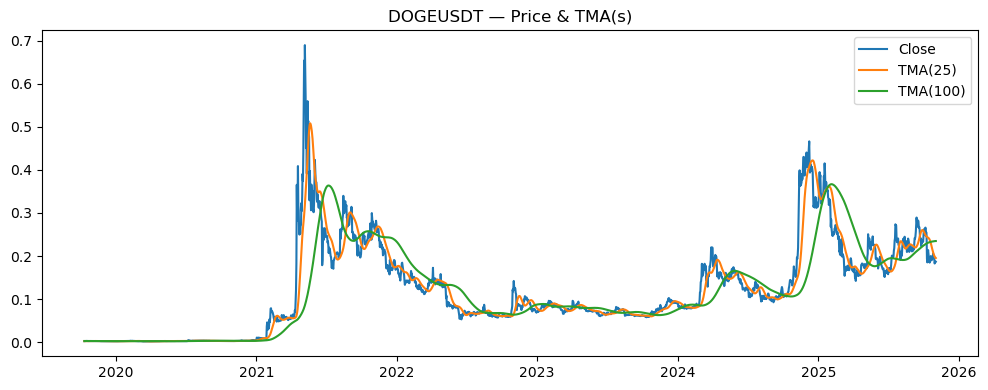

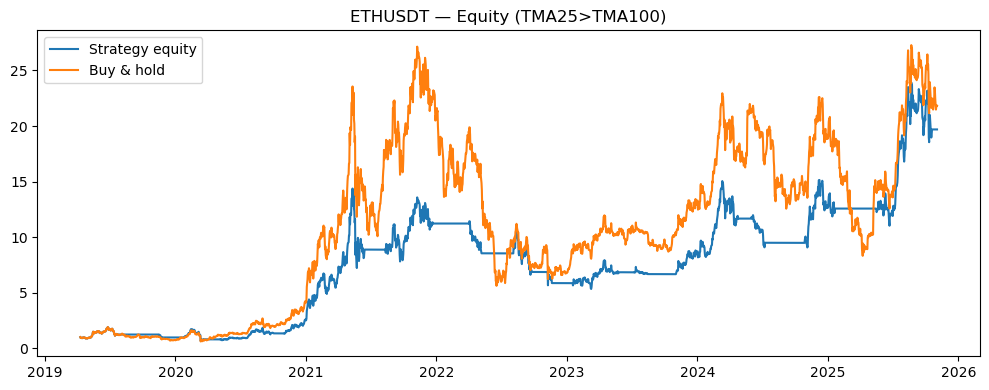

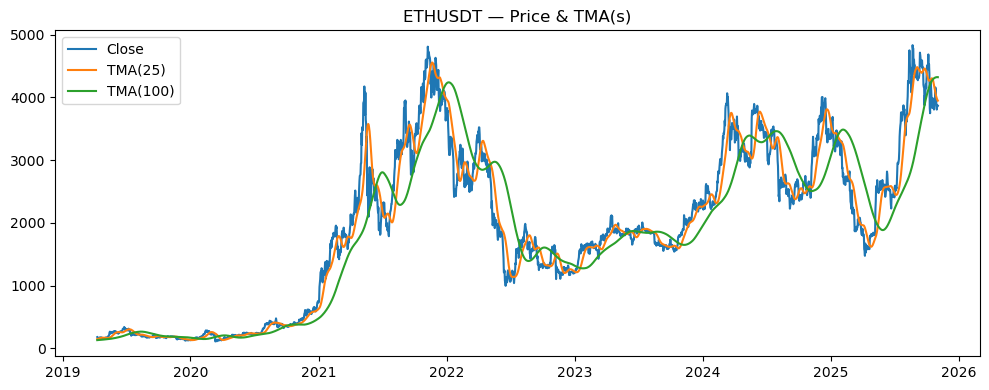

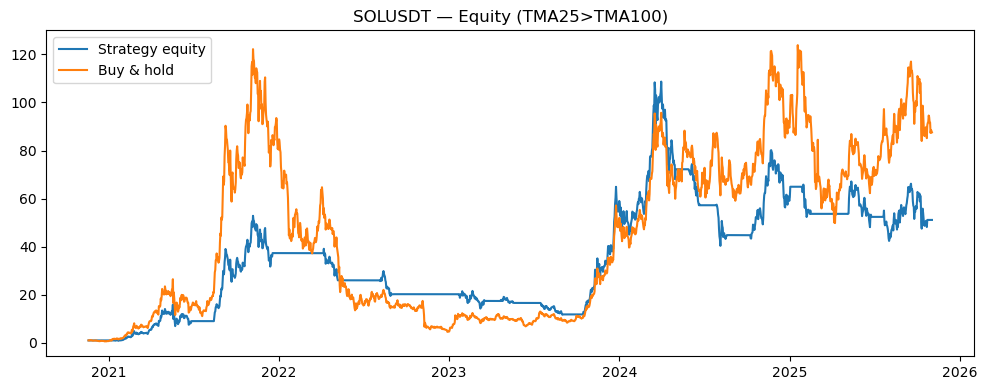

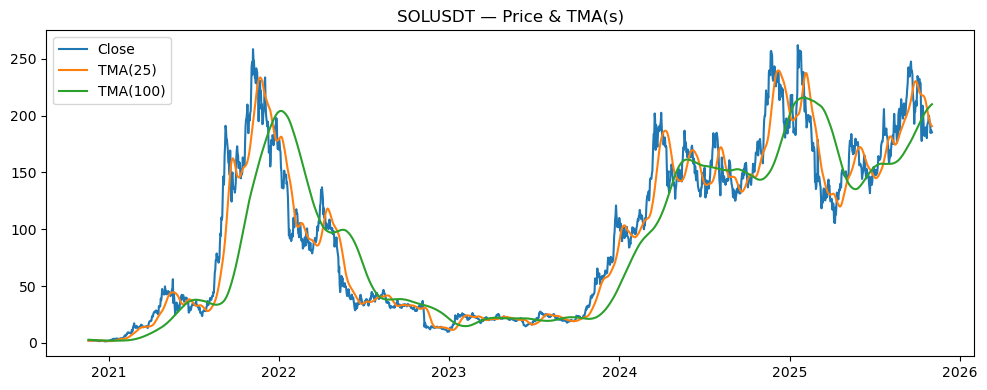

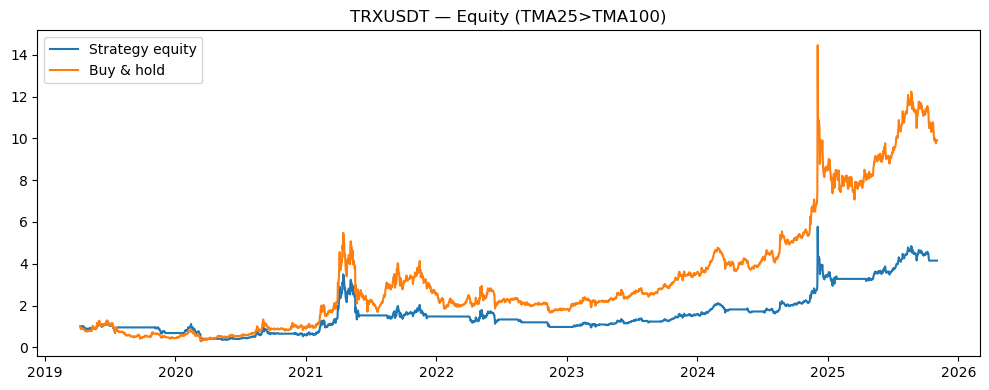

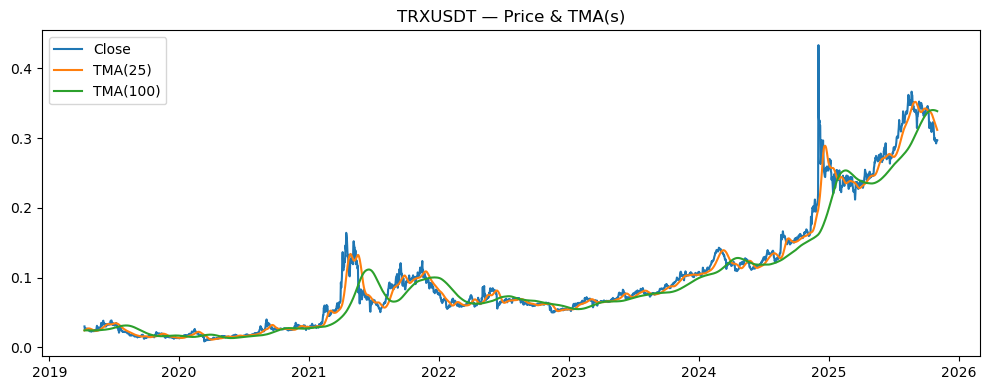

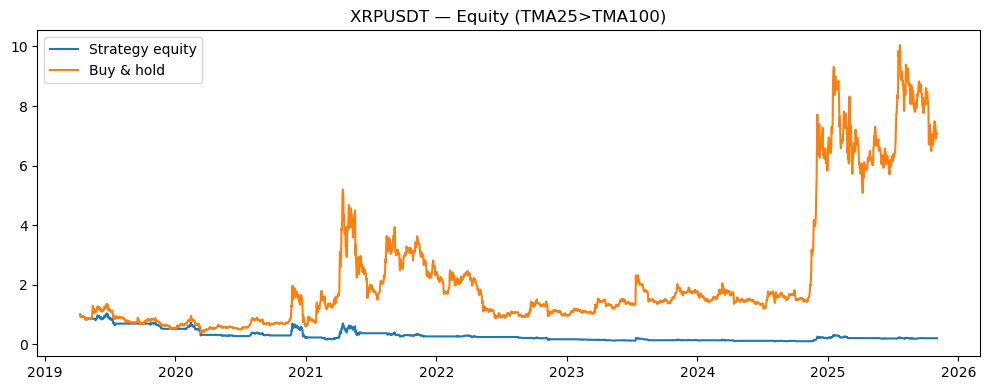

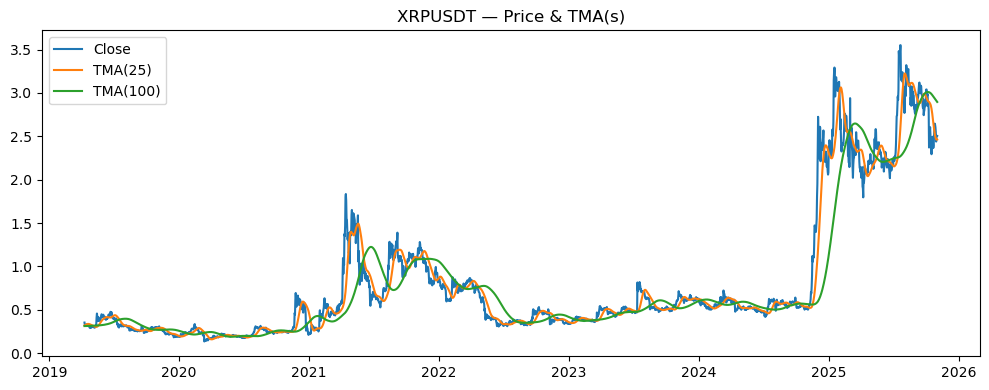

,total_return,cagr,sharpe,max_dd,calmar,trades,win_rate,avg_trade,profit_factor,bh_total_return,bh_cagr
ticker,,,,,,,,,,,
ADAUSDT,3.5515,0.2596,0.6806,-0.7151,0.3631,16,0.3750,0.6431,6.2696,5.8123,0.3394
BNBUSDT,32.7903,0.7095,1.0768,-0.7059,1.0050,16,0.4375,1.3336,15.2084,58.8777,0.8651
BTCUSDT,10.4013,0.4487,1.0039,-0.5989,0.7493,18,0.4444,0.3021,5.3777,19.7156,0.5867
DOGEUSDT,3.5861,0.2858,0.5951,-0.9833,0.2906,18,0.2222,3.7895,20.0685,79.5785,1.0636
ETHUSDT,18.6941,0.5745,1.0227,-0.6598,0.8707,15,0.5333,0.4963,7.2952,20.8349,0.5995
SOLUSDT,50.1287,1.2121,1.3483,-0.7788,1.5564,14,0.2857,1.0791,10.1645,86.5668,1.4658
TRXUSDT,3.1498,0.2420,0.6456,-0.7282,0.3324,17,0.5294,0.1552,3.0724,8.9132,0.4182
XRPUSDT,-0.7999,-0.2174,0.0940,-0.9119,-0.2384,25,0.2400,-0.0320,0.7008,6.0839,0.3474


In [24]:
symbols = sorted(p.stem for p in DATA_DIR.glob("*.csv"))
symbols = symbols[:10]
if not symbols:
    raise RuntimeError("No cached Binance CSVs found in data/. Run fetch_binance_top10.py first.")

mode = "double_tma"   # or "price_cross"
fast, slow = 25, 100
tma_window = 80        # only used for price_cross
start = "2019-01-01"
end = None
fee_bps = 10.0
allow_short = False
make_plots = True

rows = []
for symbol in symbols:
    try:
        close = load_cached_close(symbol, start=start, end=end)
    except FileNotFoundError as exc:
        print(f"[WARN] {exc}")
        continue
    if close.empty:
        print(f"[WARN] No data for {symbol}. Skipping.")
        continue
    metrics, results, trades = backtest_tma(
        close, mode=mode, tma_window=tma_window,
        fast=fast, slow=slow, allow_short=allow_short,
        fee_bps=fee_bps, make_plots=make_plots
    )
    rows.append({
        "ticker": metrics.ticker,
        "total_return": metrics.total_return,
        "cagr": metrics.cagr,
        "sharpe": metrics.sharpe,
        "max_dd": metrics.max_dd,
        "calmar": metrics.calmar,
        "trades": metrics.trades,
        "win_rate": metrics.win_rate,
        "avg_trade": metrics.avg_trade,
        "profit_factor": metrics.profit_factor,
        "bh_total_return": metrics.bh_total_return,
        "bh_cagr": metrics.bh_cagr,
    })

summary = pd.DataFrame(rows).set_index("ticker")
pd.options.display.float_format = "{:,.4f}".format
summary
